# 23S1-AI6124 Pseudo Outer-Product Fuzzy Neural Network (POPFNN) Assignment 4
Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 10 Oct 2023

Submitted by: Reinelle Jan Bugnot, Mat ID: G2304329L

## Instructions

Enter your name according to NTU Learn, and your student ID above. Do not include the square brackets. Please save the file as POPFNN_[Student name].ipynb and submit in NTU Learn.

There are 10 questions in this assignment. Please read the question and hints carefully.

## Objective
In this tutorial, you will implement derivation of fuzzy if-then rules using Pseudo Outer Product (POP) Learning in POPFNN.

After completing this tutorial, you will know:

* How to apply what you leaned in the previous tuorial assignment 3 to implement  membership functions
* How to implement a function to generate a given number of membership functions that span the input space of the data
* How to apply LVQ algorithm in the previous tutorial assignment 4 to generate membership functions from the dataset, and not just the centroids
* To to implement and apply POP learning to identify if-then-fuzzy rules using the generated membership functions and the dataset

# Introduction

Before we start, first install and import the necessary libraries.

In [1]:
!pip install -U fuzzylab
import numpy as np
import matplotlib.pyplot as plt
import sys
import fuzzylab as fz


## 1. Fuzzy Membership Function

In this tutorial, we will use the Guassian combination membership function. This function has 2 parameters more than the Gaussian membership function. Both are provided for reference. An evalmf function is also included to call the respective function to evaluate a membership output.

In [2]:
def gaussmf(x, params):
    assert len(params) == 2, 'Gaussmf function must have 2 parameters.'
    sig, c = np.asarray(params)
    return np.exp(-pow((x - c), 2) / (2 * pow(sig, 2)))

def gauss2mf(x, params):
    assert len(params) == 4, 'Gauss2mf function must have 4 parameters.'
    sig1, c1, sig2, c2 = np.asarray(params)
    assert c1 <= c2, 'c1 <= c2 is required.'
    if np.isscalar(x):
        if x<=c1:
            y=gaussmf(x, [sig1, c1])
        else:
            y=gaussmf(x,[sig2, c2])
    else:
        y = np.ones(len(x))
        idx1 = (x <= c1)
        idx2 = (x > c2)
        y[idx1] = gaussmf(x[idx1], [sig1, c1])
        y[idx2] = gaussmf(x[idx2], [sig2, c2])
    return y

# This function overwrites the evalmf function of the fuzzy logic toolbox by looking for the function name defined by
# mf.Type and calling it directly.
def evalmf(mf, x):
    possibles = globals().copy()
    possibles.update(locals())
    method = possibles.get(mf.Type)
    return method(x, mf.Parameters)

## 2. Fuzzy Membership Function class

Next we create a Fuzzy Membership function class to store the Fuzzy Membership function created, and a POPFNN class to store the input, output and fuzzy rules created.

In [3]:
class fuzzymf(object):
    def __init__(self, Type, Parameters):
        self.Type = Type
        self.Parameters = Parameters
    def __repr__(self):
            return 'fismf, '\
                ' Type: %s, '\
                ' Parameters: %s\n'\
                % (self.Type,self.Parameters)

class popfnn(object):
    In_mf:fuzzymf
    Out_mf:fuzzymf
    N_inputs:int
    N_outlabels:int
    Lut_m:np
    Lut_d:np
    N_rules:int
    Pweights:np

    def __init__(self, In_mf, Out_mf):
        self.In_mf = In_mf
        self.Out_mf = Out_mf

        self.N_inputs=len(self.In_mf)
        self.N_outlabels=len(self.Out_mf[0])
        self.Lut_m=np.empty(self.N_inputs, np.int8)
        self.Lut_d=np.empty(self.N_inputs, np.int8)

        # Calculate lookup tables for rule access
        self.N_rules = 1
        for i in range(self.N_inputs):
            self.Lut_m[i] = len(self.In_mf[i]) #n_mf
            self.Lut_d[i] = 1
            self.N_rules = self.N_rules * self.Lut_m[0]
            for j in range(i):
                self.Lut_d[j] = self.Lut_d[j] * self.Lut_m[j]

        # Initialize pseudo weights for all rules
        self.pweights = np.zeros([self.N_rules,self.N_outlabels])

    # returns the membership label given rule number and the ninput
    def getlabel(self, rule, ninput):
        return ( int((int(rule)/(self.Lut_d[ninput]))%self.Lut_m[ninput]));

    # prints all the rules
    def printruleslabels(self):
        print('N_inputs=',self.N_inputs)
        print('N_rules=',self.N_rules)
        print('N_output_mf=',self.N_outlabels)
        print('rule_number, labels, pweights')
        for i in range(self.N_rules):
            print(i,end = ' ')
            for j in range(self.N_inputs):
                print(self.getlabel(i,j),end = ' ')
            for j in range(self.N_outlabels):
                print(self.pweights[i][j],end = ' ')
            print(' ')

    def poplearn(self, x, y):
        for r in range(self.N_rules):
            min_t=1.0
            for i in range(self.N_inputs):
                # Get the label of input i for rule r
                label=self.getlabel(r,i)
                # Compute membership of input i
                t=evalmf(self.In_mf[i][label],x[i])
                # Compute min across all input membership functions
                min_t=min(min_t,t)
            for i in range(self.N_outlabels):
                t=evalmf(self.Out_mf[0][i],y)
                self.pweights[r][i]+=min_t*t

    #Enter code for question 8 here


## 3. Learning Fuzzy Membership function by spanning the input space

Next we crate a simple function to generate a given number of membership functions that span the input space of the data.

In [4]:
# This function creates nlabels number of gauss2mf that spans min and max of the inputs
def span_learnmem(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, width = np.asarray(params)
    nlabels=int(nlabels)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis=[]
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width
        mf=[]
        for j in range(nlabels):
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


## 4. Generate Training dataset

Now we generate a dataset to train the Neuro Fuzzy System.

Text(0, 0.5, '$x_2$')

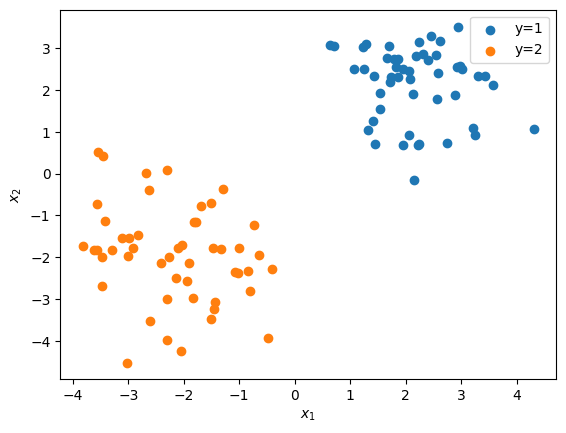

In [5]:
dataset = np.random.randn(100,2)
dataset[0:50]+=(+2)
dataset[50:100]+=(-2)
labels=np.array([1]*50)
labels=np.append(labels,[2]*50)
#labels=labels.transpose()
plt.scatter(dataset[labels==1,0], dataset[labels==1,1])
plt.scatter(dataset[labels==2,0], dataset[labels==2,1])
plt.legend(['y=1','y=2'])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## 5. Train the fuzzy membership functions

Now we begin to train the fuzzy membership functions. After POPFNN initializes the rule space based on the input and output membership functions. The function printrulelabels prints out all the rules, the membership function labels for each input, and the pseudo weights of each rule.

In [6]:
inmf = span_learnmem(dataset, [2.0, 0.5])
outmf = span_learnmem(labels, [2.0, 0.5])
nf=popfnn(In_mf=inmf, Out_mf=outmf)
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0  
1 0 1 0.0 0.0  
2 1 0 0.0 0.0  
3 1 1 0.0 0.0  


<font color=red>Question 1</font>: How many rules are initialized in the above code? <font color='red'>(1 mark)</font>

**ANSWER**: 4 Rules

<font color=red>Question 2</font>: How many rules are generated if you change span_learnmem to generate 4 membership functions instead of 2? <font color='red'>(1 mark)</font>

In [7]:
# Modify code for question 2 here
inmf2 = span_learnmem(dataset, [4.0, 0.5])
outmf2 = span_learnmem(labels, [4.0, 0.5])
nf2=popfnn(In_mf=inmf2, Out_mf=outmf2)
nf2.printruleslabels()

N_inputs= 2
N_rules= 16
N_output_mf= 4
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0 0.0  
3 0 3 0.0 0.0 0.0 0.0  
4 1 0 0.0 0.0 0.0 0.0  
5 1 1 0.0 0.0 0.0 0.0  
6 1 2 0.0 0.0 0.0 0.0  
7 1 3 0.0 0.0 0.0 0.0  
8 2 0 0.0 0.0 0.0 0.0  
9 2 1 0.0 0.0 0.0 0.0  
10 2 2 0.0 0.0 0.0 0.0  
11 2 3 0.0 0.0 0.0 0.0  
12 3 0 0.0 0.0 0.0 0.0  
13 3 1 0.0 0.0 0.0 0.0  
14 3 2 0.0 0.0 0.0 0.0  
15 3 3 0.0 0.0 0.0 0.0  


**ANSWER**: 16 rules

Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

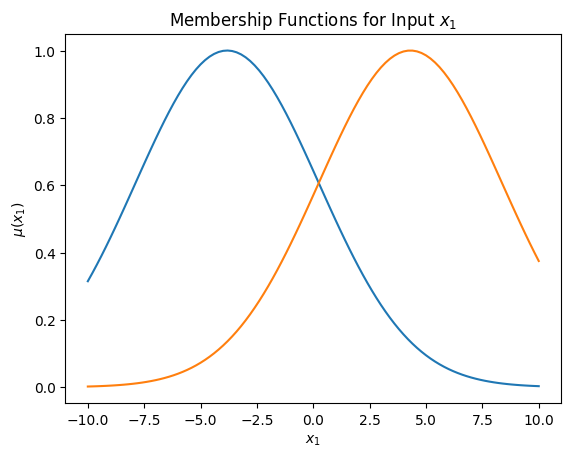

In [8]:
x = np.linspace(-10, 10, 101)
plt.plot(x, evalmf(inmf[0][0], x))
plt.plot(x, evalmf(inmf[0][1], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

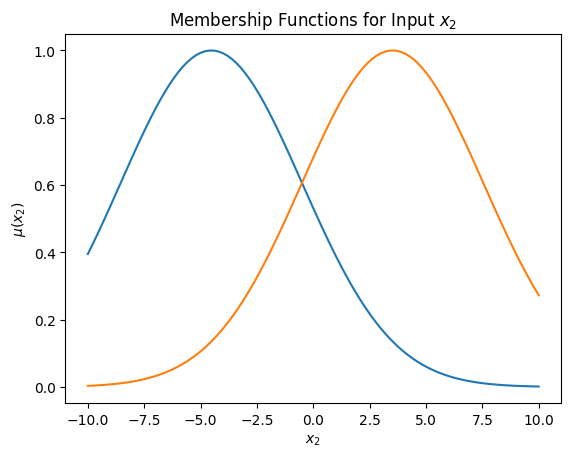

In [9]:
plt.plot(x, evalmf(inmf[1][0], x))
plt.plot(x, evalmf(inmf[1][1], x))
plt.xlabel('$x_2$')
plt.ylabel('$\mu(x_2)$')
plt.title('Membership Functions for Input $x_2$')

Text(0.5, 1.0, 'Membership Functions for Output $y_1$')

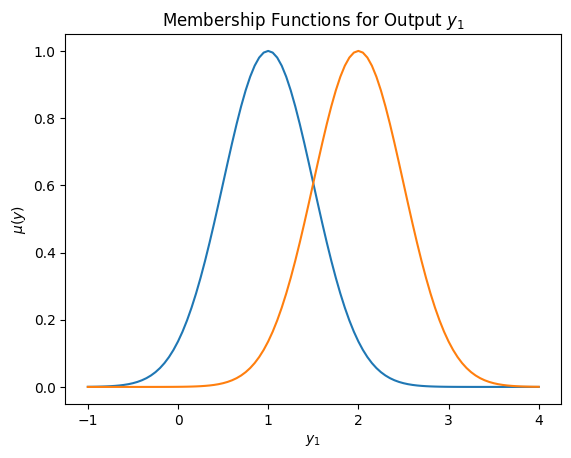

In [10]:
y = np.linspace(-1, 4, 101)
plt.plot(y, evalmf(outmf[0][0], y))
plt.plot(y, evalmf(outmf[0][1], y))
plt.xlabel('$y_1$')
plt.ylabel('$\mu(y)$')
plt.title('Membership Functions for Output $y_1$')

<font color=red>Question 3</font>: Modify the span_learnmem to include a parameter tail. If parameter is true, one end of the left most and right most membership function will yield 1, but not the middle of the membership function. Hint: Change one of the parameters. Another hint, the value is one from the sys module. <font color='red'>(1 mark)</font>

In [11]:
## DONE
# Simple solution: move bounding centroids extremely far

def span_learnmem3(x, params):

    assert len(params) == 3, 'spam_learnmem function must have 3 parameters.'
    nlabels, width, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis = []
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))
        sig=(centroids[1]-centroids[0])*width
        mf=[]
        for j in range(nlabels):
          if j == 0 and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -1e6, sig, centroids[j]])) ## <--
          elif j == (nlabels-1) and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, 1e6])) ## <--
          else:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


<font color=red>Question 4</font>: Use the above modified span_learnmem and plot nlabels=3 membership functions with tail=true for $x_1$ <font color='red'>(1 mark)</font>

N_inputs= 2
N_rules= 9
N_output_mf= 3
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0  
3 1 0 0.0 0.0 0.0  
4 1 1 0.0 0.0 0.0  
5 1 2 0.0 0.0 0.0  
6 2 0 0.0 0.0 0.0  
7 2 1 0.0 0.0 0.0  
8 2 2 0.0 0.0 0.0  


Text(0.5, 1.0, 'Membership Functions for Input $x_1$')

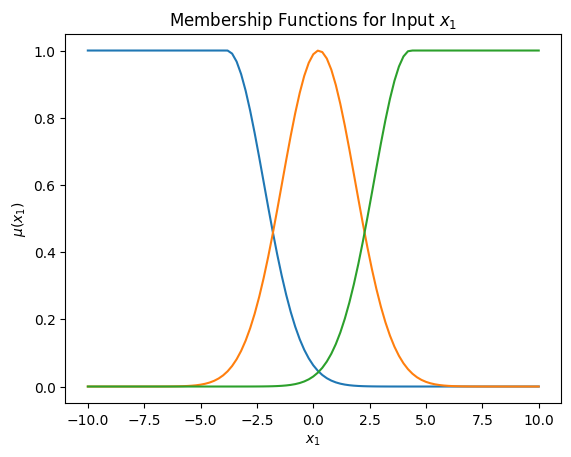

In [12]:
## DONE
nlabels = 3.0
dim = 0 # <- x_1

inmf3 = span_learnmem3(dataset, [nlabels, 0.4, True])
outmf3 = span_learnmem3(labels, [nlabels, 0.4, True])
nf3=popfnn(In_mf=inmf3, Out_mf=outmf3)
nf3.printruleslabels()

x = np.linspace(-10, 10, 101)
plt.plot(x, evalmf(inmf3[dim][0], x))
plt.plot(x, evalmf(inmf3[dim][1], x))
plt.plot(x, evalmf(inmf3[dim][2], x))
plt.xlabel('$x_1$')
plt.ylabel('$\mu(x_1)$')
plt.title('Membership Functions for Input $x_1$')

<font color=red>Question 5</font>: Now modify span_learnmem to delete the width parameter and automatically compute the width such that the membership functions intersect at value $\mu=0.5$ in the middle of the centroid. Retain the tail parameter. <font color='red'>(1 mark)</font>

In [13]:
def calc_intersect(x, intersect_pt, centroid_dist, centroid_0, centroid_1):
  return gauss2mf(centroid_0 + ((centroid_dist) * 0.5), [x, centroid_0, x, centroid_1]) - intersect_pt

In [14]:
## DONE
from scipy.optimize import fsolve
def span_learnmem4(x, params):

    assert len(params) == 2, 'spam_learnmem function must have 2 parameters.'
    nlabels, tail = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis = []
    for i in range(ninputs):
        if ninputs==1:
            centroids=np.linspace(minx,maxx,int(nlabels))
        else:
            centroids=np.linspace(minx[i],maxx[i],int(nlabels))

        centroid_dist = centroids[1]-centroids[0]

        if i == 0:
          root = fsolve(calc_intersect, 0.1, args=(0.5, centroid_dist, centroids[0], centroids[1])) # The roots of the function correspond to a valid sigma value
          width = root / centroid_dist # calculate the width parameter from the calculated root value
        sig = centroid_dist * width

        mf=[]
        for j in range(nlabels):
          if j == 0 and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -1000, sig, centroids[j]]))
          elif j == (nlabels-1) and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, 1000]))
          else:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


<font color=red>Question 6</font>: Use the above modified span_learnmem and plot nlabels=4 membership functions with tail=true for $x_2$ <font color='red'>(1 mark)</font>

N_inputs= 2
N_rules= 16
N_output_mf= 4
rule_number, labels, pweights
0 0 0 0.0 0.0 0.0 0.0  
1 0 1 0.0 0.0 0.0 0.0  
2 0 2 0.0 0.0 0.0 0.0  
3 0 3 0.0 0.0 0.0 0.0  
4 1 0 0.0 0.0 0.0 0.0  
5 1 1 0.0 0.0 0.0 0.0  
6 1 2 0.0 0.0 0.0 0.0  
7 1 3 0.0 0.0 0.0 0.0  
8 2 0 0.0 0.0 0.0 0.0  
9 2 1 0.0 0.0 0.0 0.0  
10 2 2 0.0 0.0 0.0 0.0  
11 2 3 0.0 0.0 0.0 0.0  
12 3 0 0.0 0.0 0.0 0.0  
13 3 1 0.0 0.0 0.0 0.0  
14 3 2 0.0 0.0 0.0 0.0  
15 3 3 0.0 0.0 0.0 0.0  


<ipython-input-2-74025eb34950>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig1, c1, sig2, c2 = np.asarray(params)
<ipython-input-2-74025eb34950>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig, c = np.asarray(params)


Text(0.5, 1.0, 'Membership Functions for Input $x_2$')

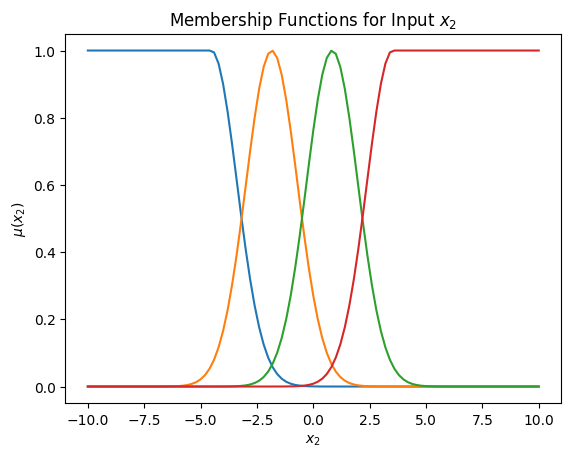

In [15]:
## DONE
nlabels = 4.0
dim = 1 # <-- x_2

inmf4 = span_learnmem4(dataset, [nlabels, True])
outmf4 = span_learnmem4(labels, [nlabels, True])
nf4=popfnn(In_mf=inmf4, Out_mf=outmf4)
nf4.printruleslabels()

x = np.linspace(-10, 10, 101)
for i in range(int(nlabels)):
  plt.plot(x, evalmf(inmf4[1][i], x))
plt.xlabel(f'$x_{dim+1}$')
plt.ylabel(f'$\mu(x_{dim+1})$')
plt.title(f'Membership Functions for Input $x_{dim+1}$')

<font color=red>Question 7</font>: Now create a new LVQ_learnmem with nlabels and tail parameters. Then plot nlabels=2 membership functions with tail=true for $x_1$. Refer to code from previous tutorial. <font color='red'>(1 mark)</font>

In [16]:
# FROM ASSIGNMENT 3 -- Get all functions relevant to the LVQ algorithm
from random import randrange
from math import sqrt

# Train a set of codebook vectors
def train_LVQ(traindata, weights, lrate, epochs):
    #print("Weights:",weights)
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        sum_error = 0.0
        for row in traindata:
            winner_index = find_winner(weights, row)
            #print("Winner:",winner)
            error = (row - weights[winner_index])
            sum_error = sum_error + sqrt(sum(error**2))
            # This line has an error in changing the original dataset
            # weights[winner_index] += rate * error
            weights[winner_index] = weights[winner_index] + rate * error
            #print("Winner:",winner)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
    return weights

# Assign a random codebook vector from the training data
def random_weight(traindata):
    n_records = len(traindata)
    weight = traindata[randrange(n_records)]
    return weight

# Locate the best matching unit
def find_winner(weights, test_sample):
    distances = list()
    for weight_index, weight in enumerate(weights):
        dist = euclidean_distance(weight, test_sample)
        distances.append((weight_index, dist))
    distances.sort(key=lambda tuple: tuple[1])
    return distances[0][0]

# A more effective way
def euclidean_distance(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

In [17]:
## DONE
from scipy.optimize import fsolve
def span_learnmem5(x, params):

    assert len(params) == 3, 'spam_learnmem function must have 3 parameters.'
    nlabels, tail, winning_vector = np.asarray(params)
    nlabels=int(nlabels)
    tail=bool(tail)

    # First get the max and min of each dimension
    maxx=np.amax(x, axis=0)
    minx=np.amin(x, axis=0)

    if x.ndim==1:
        ninputs=1
    else:
        ninputs=np.size(x,1)

    fis = []
    for i in range(ninputs):

        centroids = winning_vector

        centroid_dist = centroids[1]-centroids[0]

        if i == 0:
          root = fsolve(calc_intersect, 0.1, args=(0.5, centroid_dist, centroids[0], centroids[1])) # The roots of the function correspond to a valid sigma value
          width = root / centroid_dist # calculate the width parameter from the calculated root value
        sig = centroid_dist * width

        mf=[]
        for j in range(nlabels):
          if j == 0 and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, -1000, sig, centroids[j]]))
          elif j == (nlabels-1) and tail:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, 1000]))
          else:
            mf.append(fuzzymf(Type = 'gauss2mf', Parameters = [sig, centroids[j], sig, centroids[j]]))
        fis.append(mf)
    return fis


In [18]:
# CALCULATE EVERYTHING
nlabels = 2
tail = True
dim = 0 # <- x_1

x = np.linspace(-6, 6, 101)

# LVQ
learn_rate = 0.3
n_epochs = 10
weights = train_LVQ(dataset, [random_weight(dataset) for i in range(nlabels)], learn_rate, n_epochs)
nweights=np.array(weights)
area = np.pi*3

# Membership Function Generation
inmf5 = span_learnmem5(dataset, [nlabels, tail, np.sort(nweights[:, dim])])
outmf5 = span_learnmem5(labels, [nlabels, tail, np.sort(nweights[:, dim])])
nf5=popfnn(In_mf=inmf5, Out_mf=outmf5)
nf5.printruleslabels()

>epoch=0, lrate=0.300, error=131.746
>epoch=1, lrate=0.270, error=130.277
>epoch=2, lrate=0.240, error=129.028
>epoch=3, lrate=0.210, error=127.818
>epoch=4, lrate=0.180, error=126.783
>epoch=5, lrate=0.150, error=125.824
>epoch=6, lrate=0.120, error=124.842
>epoch=7, lrate=0.090, error=123.800
>epoch=8, lrate=0.060, error=122.704
>epoch=9, lrate=0.030, error=121.431
N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 0.0 0.0  
1 0 1 0.0 0.0  
2 1 0 0.0 0.0  
3 1 1 0.0 0.0  


<ipython-input-17-0827736119b9>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nlabels, tail, winning_vector = np.asarray(params)
<ipython-input-2-74025eb34950>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig1, c1, sig2, c2 = np.asarray(params)
<ipython-input-2-74025eb34950>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  si

<ipython-input-2-74025eb34950>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig1, c1, sig2, c2 = np.asarray(params)
<ipython-input-2-74025eb34950>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sig, c = np.asarray(params)


Text(0.5, 1.0, 'Membership Functions for Input Dataset $x_1$')

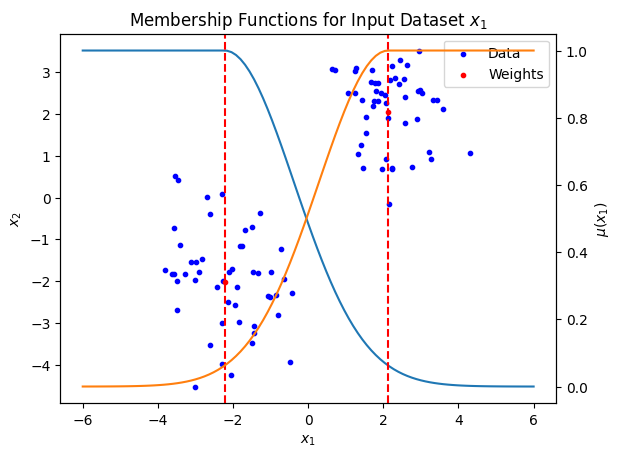

In [19]:
# PLOT -- DONE
fig, ax = plt.subplots()

ax.scatter(dataset[:,0], dataset[:,1],area,c="blue",label="Data")
ax.scatter(nweights[:,0], nweights[:,1],area,c="red",label="Weights")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

ax2 = ax.twinx()

for i in range(int(nlabels)):
  ax2.plot(x, evalmf(inmf5[1][i], x))
  ax2.axvline(np.sort(nweights[:, 0])[i], color='r', linestyle='--')

ax2.set_xlabel(f'$x_{dim+1}$')
ax2.set_ylabel(f'$\mu(x_{dim+1})$')
ax2.set_title(f'Membership Functions for Input Dataset $x_{dim+1}$')

## 6. Train the POPFNN using POP learning
Finally we train the POPFNN Neuro Fuzzy System using Pseudo Outer-Product Learning algorithm. Becareful that you do not change nf along the way. This code below should produce only 4 if then fuzzy rules.

In [20]:
# Perform POP learning
for k in range(len(dataset)):
    nf.poplearn(dataset[k],labels[k])
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 16.88209007686843 39.88700924316099  
1 0 1 19.987489513775564 22.813302136998775  
2 1 0 15.080562943799155 16.348954950429786  
3 1 1 43.50379642431566 18.517479196219803  


<font color=red>Question 8</font>: Examine the pseudo weights for each output label in the output above. Create a function in POPFNN class call identify rules to identify the consequent for each rule. Also modify the printruleslabels function to print the label of the consequent after the pseudo weight. <font color='red'>(1 mark)</font>

In [21]:
# Enter code here for Question 8.
nf.printruleslabels()

N_inputs= 2
N_rules= 4
N_output_mf= 2
rule_number, labels, pweights
0 0 0 16.88209007686843 39.88700924316099  
1 0 1 19.987489513775564 22.813302136998775  
2 1 0 15.080562943799155 16.348954950429786  
3 1 1 43.50379642431566 18.517479196219803  


<font color=red>Question 9</font>: Now change the generation of membership function to LVQ with nlabels=2 and tail=true. Retrain the fuzzy rules and print the rules for inspection. Any changes in the rules identified? <font color='red'>(1 mark)</font>

In [ ]:
# Enter code for Question 9.


<font color=red>Question 10</font>: Now inspect the pseudo weights again. Some of the rules have pseudo weights that are very similar for both output labels. Implement another function to identify the more significant rules such that the pseduo weight for a particular output label is much higher than the other output labels. <font color='red'>(1 mark)</font>

In [ ]:
# Enter code for Question 10.